# Baselines

## Motivation

Create a set of baselines for demand prediction using conventional methods:

* time series prediction
* per cell prediction using any type of regressor, e.g. gradient boosting regressor

**TODO**
- define a small area 10x10 squares
- explore demand over time changes - how small time prediction intervals should be

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [61]:
data = pd.read_feather('../data/train_sample.feather')

data.head(3)

,pickup_datetime,dropoff_datetime,passenger_count,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,2015-01-01 00:00:00,2015-01-01 00:00:00,3,2.510570,-74.001320,40.729057,-74.010208,40.719662
1,2015-01-01 00:00:03,2015-01-01 00:10:50,1,2.542757,-73.987579,40.765270,-73.976921,40.776970
2,2015-01-01 00:00:03,2015-01-01 00:21:48,2,4.136004,-73.969017,40.754269,-73.994133,40.761600


Create a grid and count the *number of requests per cell*

## Select a small area

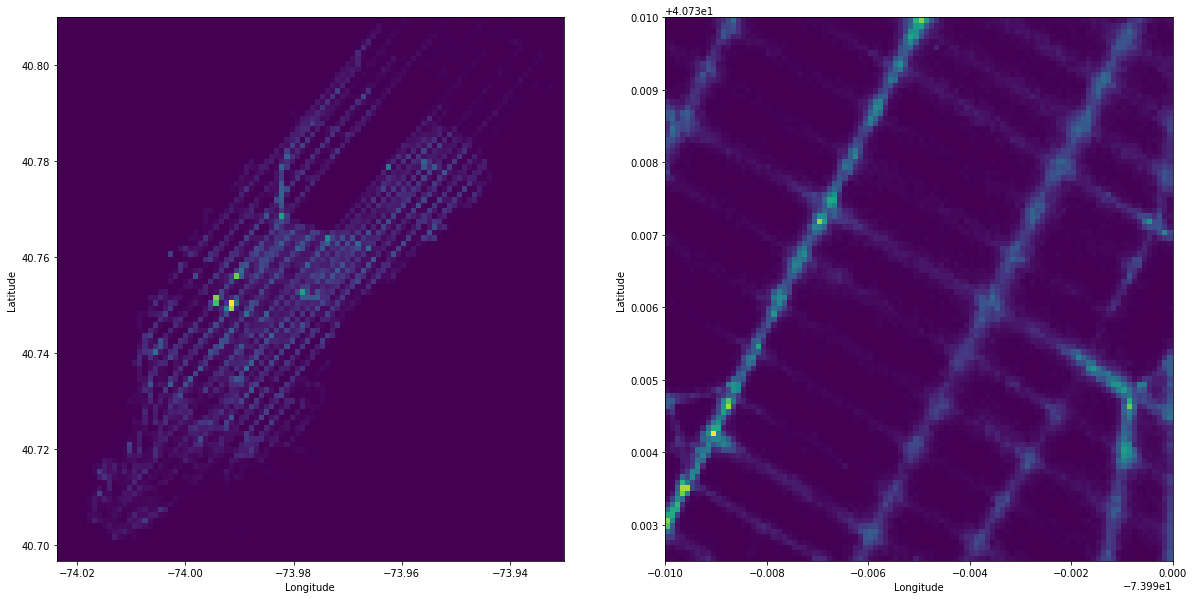

In [131]:
plt.figure(figsize=(20, 10))

bounding_box = ((-74.0238, -73.93), (40.6967, 40.81))

sample_box = ((-74.00, -73.99), (40.7325, 40.74))

bins = (100, 100)

for i, box in enumerate([bounding_box, sample_box]):
    plt.subplot(1, 2, i + 1)
    
    plt.hist2d(
        data.pickup_lon,
        data.pickup_lat,
        range=box, bins=bins)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

## Number of requests per day

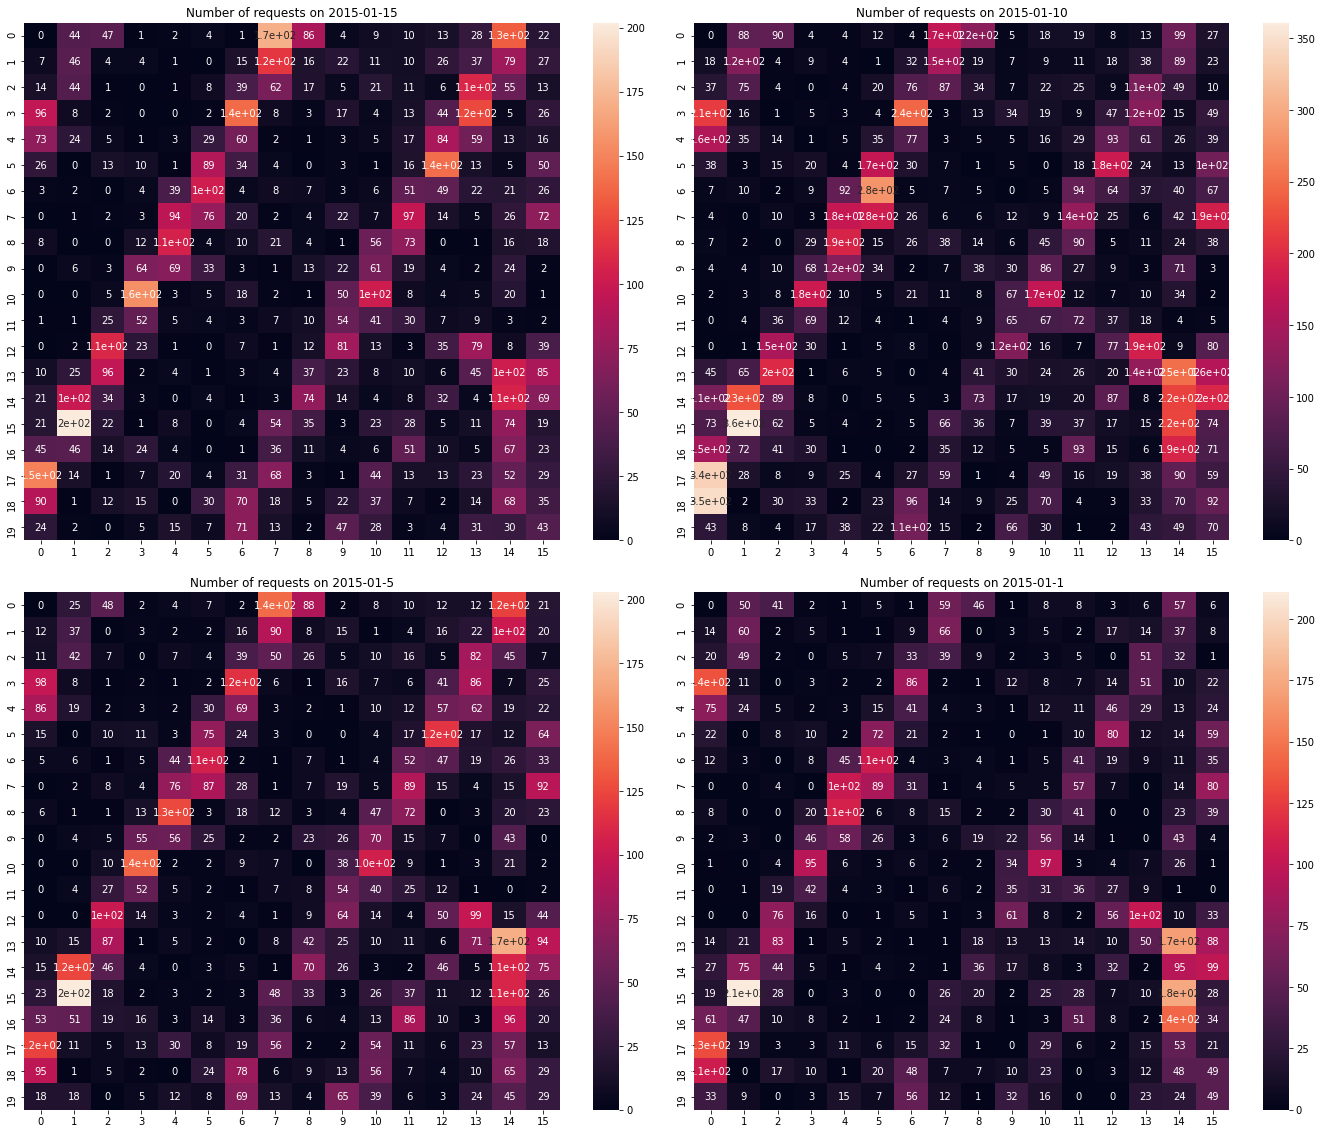

In [159]:
plt.figure(figsize=(24, 20))

bins = (16, 20)

for i, date in enumerate(
        ['2015-01-15', '2015-01-10', '2015-01-5', '2015-01-1']):

    plt.subplot(2, 2, i + 1)

    idx = data.pickup_datetime.dt.date == pd.to_datetime(date)

    hist, _, _ = np.histogram2d(data[idx].pickup_lon,
                                data[idx].pickup_lat,
                                range=sample_box,
                                bins=bins)

    plt.title(f'Number of requests on {date}')
    sns.heatmap(np.flip(np.fliplr(hist.T)), annot=True)

plt.subplots_adjust(wspace=0, hspace=0.1)

## Number of requests per hour

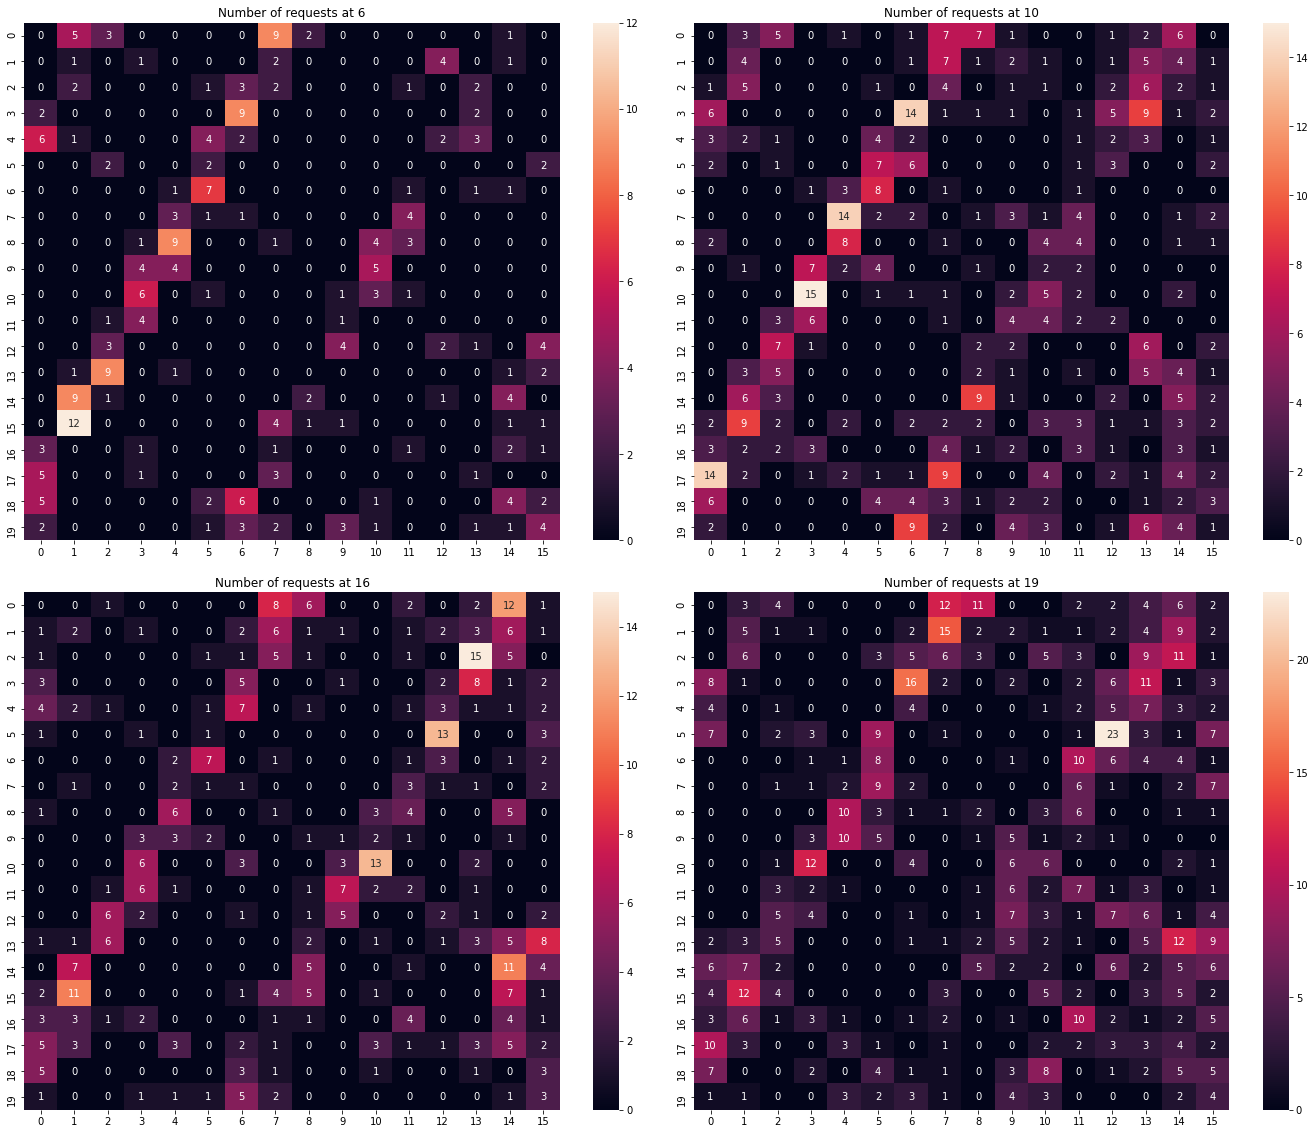

In [170]:
plt.figure(figsize=(24, 20))

bins = (16, 20)
hour = 10
date = '2015-01-15'

for i, hour in enumerate([6, 10, 16, 19]):

    plt.subplot(2, 2, i + 1)

    idx = (data.pickup_datetime.dt.date == pd.to_datetime(
        date)) & (data.pickup_datetime.dt.hour == hour)

    hist, _, _ = np.histogram2d(data[idx].pickup_lon,
                                data[idx].pickup_lat,
                                range=sample_box,
                                bins=bins)

    plt.title(f'Number of requests at {hour}')
    sns.heatmap(np.flip(np.fliplr(hist.T)), annot=True)

plt.subplots_adjust(wspace=0, hspace=0.1)